In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data() # load dataset
train_images, test_images = train_images/255, test_images/255 # normalize

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Flatten()) # flattens the 4x4x64 into a 1d input
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10)) # 10-class output
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [6]:
# training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images,test_labels))

Epoch 1/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.5308 - accuracy: 0.4419 - val_loss: 1.2606 - val_accuracy: 0.5437
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.1445 - accuracy: 0.5953 - val_loss: 1.1284 - val_accuracy: 0.5943
Epoch 3/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.9903 - accuracy: 0.6530 - val_loss: 0.9562 - val_accuracy: 0.6635
Epoch 4/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8904 - accuracy: 0.6891 - val_loss: 0.9031 - val_accuracy: 0.6803
Epoch 5/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.8248 - accuracy: 0.7103 - val_loss: 0.9312 - val_accuracy: 0.6748
Epoch 6/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.7713 - accuracy: 0.7315 - val_loss: 0.9212 - val_accuracy: 0.6799
Epoch 7/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.7239 - accuracy: 0.7458 - val_loss: 0.8601 - va

In [7]:
# evaluating
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
test_loss, test_acc

313/313 - 1s - loss: 0.8756 - accuracy: 0.7087 - 999ms/epoch - 3ms/step


(0.875558614730835, 0.7087000012397766)

# small dataset problems
- lots of data is ideal, big ones are trained on many millions of images
- difficult to get a good network with small datasets
## data augmentation
- we can make one image into multiple by transforming it, should make the model better at generalizing


In [3]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

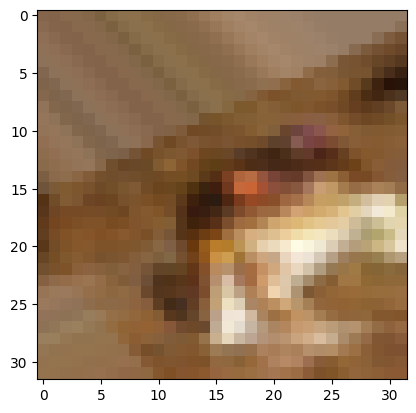

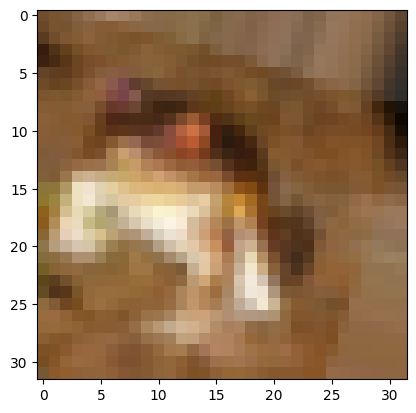

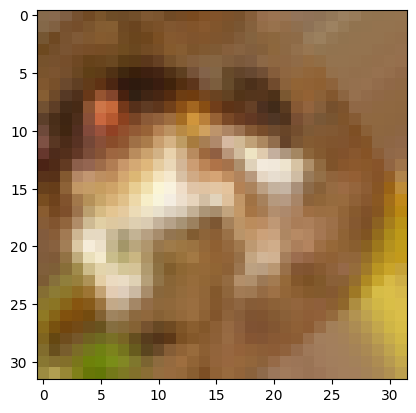

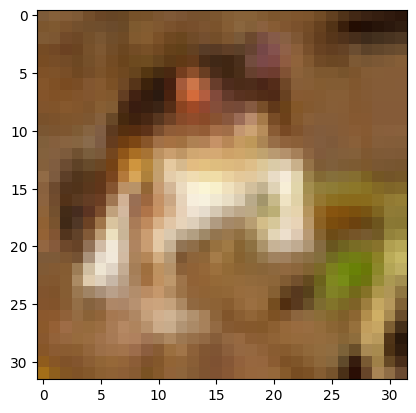

In [4]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
) # not gonna go into what each of these mean

# trainsforming one image:
test_img = train_images[0]
img = image.img_to_array(test_img)
img = img.reshape((1,) + img.shape)

i = 0
for batch in datagen.flow(img,save_prefix='test', save_format='jpeg'): # will run forever until we break, saving images to current directory
    plt.figure(i)
    plot = plt.imshow(image.img_to_array(batch[0]))
    i += 1
    if i >= 4: # show 4 images
        break

plt.show()

## pretrained models
- data augmentation can help, but not always enough
- big companies have big computers to make big models
- gonna use part of their models as a base for our model to fine tune for our work
- use the part of their model that's good at generalizing then add our own crap on top to do what we want

In [5]:
import os
import numpy as np
keras = tf.keras

In [7]:
import tensorflow_datasets as tfds
# make downloading progress bar dissable 
tfds.disable_progress_bar()

# setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# split data into 80% training, 10% testing, 10% validation
# not explaining this, see documentation
# seems to only be working on macos
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

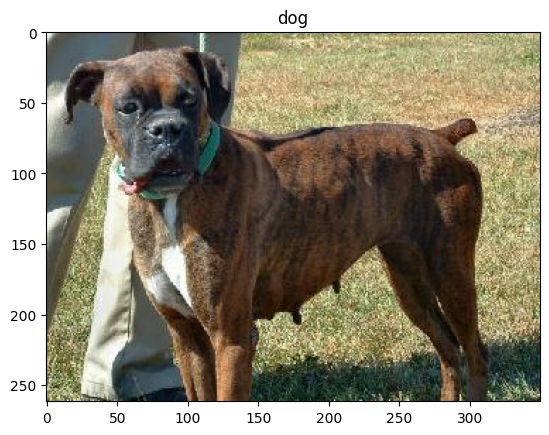

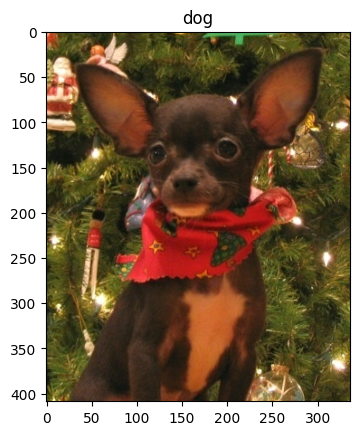

In [8]:
get_label_name = metadata.features['label'].int2str # create a function object we can use to get labels

# display 2 images from the dataset
for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [18]:
# gonna resize to all be the same
IMG_SIZE = 160
def format_example(image,label):
    image = tf.cast(image, tf.float32)
    # image = (image/127.5) - 1
    # takes only color values above 127 in the original data, what the fuck is this???
    # i refuse to do this
    image = image/255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [19]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

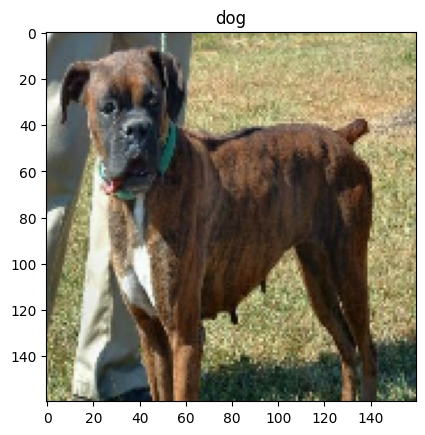

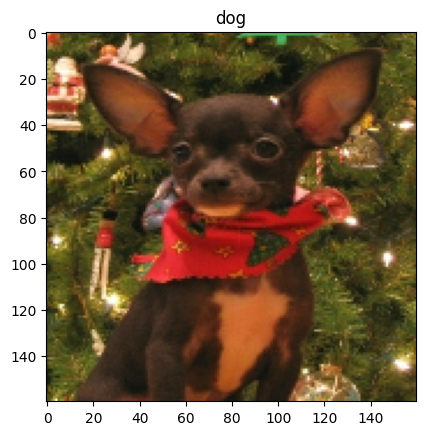

In [20]:
for image, label in train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))